# Junk Classification

Questo notebook contiene l'intera pipeline di lavoro svolto al fine di ottenere una rete neurale per la classificazione di immagini di rifiuti.
Per l'esecuzione è consigliato l'utilizzo di una GPU.

## Operazioni Preliminari
Cloniamo il repository del dataset e lo estraiamo dopo aver specificato alcuni import. 
Ci accertiamo che tutto sia stato eseguito correttamente verificando il numero di immagini presenti nella cartella estratta.


In [1]:
!git clone https://github.com/garythung/trashnet.git

Cloning into 'trashnet'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 39 (delta 2), reused 0 (delta 0), pack-reused 33
Unpacking objects: 100% (39/39), done.


In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import zipfile

import tensorflow as tf

from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
with zipfile.ZipFile("/content/trashnet/data/dataset-resized.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/trashnet/data/dataset-resized")

In [5]:
data_dir = pathlib.Path("/content/trashnet/data/dataset-resized/dataset-resized")

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2527


# Definizione Modello Base
Definiamo le costanti utilizzate e effettuiamo lo splitting del dataset.
Definiamo l'architettura di partenza del modello utilizzato e eseguiamo un primo training per visualizzare la performance iniziale del modello.

### Costanti

In [6]:
CARDBOARD = 0
GLASS = 1
METAL = 2
PAPER = 3
PLASTIC = 4
TRASH = 5

DIM1 = 384
DIM2 = 512

batch_size = 32
img_height = DIM1
img_width = DIM2


### Train e Validation Set


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [10]:
num_classes = len(class_names)

### Ottimizzazione prestazioni


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Architettura Base

Compreso un layer di standardizzazione per i valori del canale RGB
[0, 255] -> [0, 1]

In [ ]:


model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 384, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 384, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 192, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 96, 128, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 128, 64)       1

### Training e Visualizzazione Risultati

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
64/64 [==============================] - 30s 145ms/step - loss: 2.2982 - accuracy: 0.2819 - val_loss: 1.4881 - val_accuracy: 0.4079
Epoch 2/10
64/64 [==============================] - 7s 104ms/step - loss: 1.4048 - accuracy: 0.4283 - val_loss: 1.3624 - val_accuracy: 0.4634
Epoch 3/10
64/64 [==============================] - 7s 103ms/step - loss: 1.2169 - accuracy: 0.5287 - val_loss: 1.2087 - val_accuracy: 0.5050
Epoch 4/10
64/64 [==============================] - 7s 109ms/step - loss: 0.9496 - accuracy: 0.6355 - val_loss: 1.1514 - val_accuracy: 0.5743
Epoch 5/10
64/64 [==============================] - 7s 104ms/step - loss: 0.7196 - accuracy: 0.7483 - val_loss: 1.2931 - val_accuracy: 0.5663
Epoch 6/10
64/64 [==============================] - 7s 105ms/step - loss: 0.5360 - accuracy: 0.8116 - val_loss: 1.4728 - val_accuracy: 0.5406
Epoch 7/10
64/64 [==============================] - 7s 115ms/step - loss: 0.3626 - accuracy: 0.8808 - val_loss: 1.4395 - val_accuracy: 0.5881
Epoch

In [12]:
def print_results(history, epochs):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


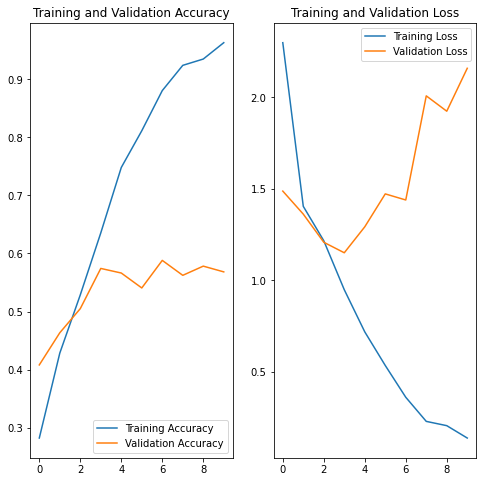

In [ ]:
print_results(history, epochs)

## Modello Migliorato
I risultati precedenti evidenziano l'overfitting del modello.
* Aggiungiamo un layer di Data Augmentation per migliorare le prestazioni
* Aggiungiamo un layer di Dropout per ridurre l'overfitting
* Rendiamo l'architettura più profonda, aggiungendo un layer convoluzionale.

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.3)
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
64/64 [==============================] - 11s 141ms/step - loss: 1.7474 - accuracy: 0.2760 - val_loss: 1.6884 - val_accuracy: 0.2871
Epoch 2/15
64/64 [==============================] - 8s 125ms/step - loss: 1.4831 - accuracy: 0.3882 - val_loss: 1.3391 - val_accuracy: 0.4752
Epoch 3/15
64/64 [==============================] - 8s 126ms/step - loss: 1.3448 - accuracy: 0.4659 - val_loss: 1.2272 - val_accuracy: 0.5069
Epoch 4/15
64/64 [==============================] - 8s 126ms/step - loss: 1.2695 - accuracy: 0.4891 - val_loss: 1.4574 - val_accuracy: 0.4257
Epoch 5/15
64/64 [==============================] - 8s 126ms/step - loss: 1.2945 - accuracy: 0.5079 - val_loss: 1.2417 - val_accuracy: 0.5366
Epoch 6/15
64/64 [==============================] - 8s 126ms/step - loss: 1.2189 - accuracy: 0.5346 - val_loss: 1.1644 - val_accuracy: 0.5347
Epoch 7/15
64/64 [==============================] - 8s 126ms/step - loss: 1.1667 - accuracy: 0.5495 - val_loss: 1.1098 - val_accuracy: 0.5683
Epoch

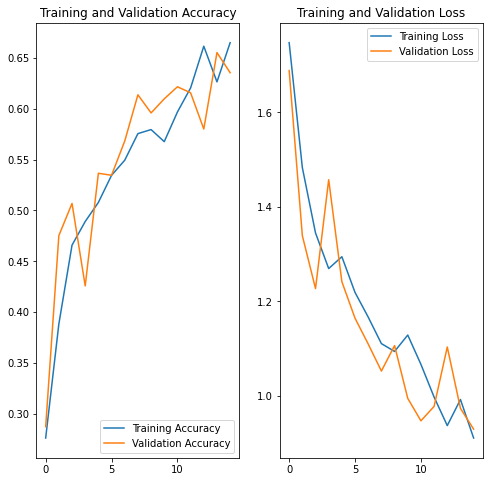

In [ ]:
print_results(history, epochs)

# HyperTuning
Cerchiamo la configurazione migliore del modello attraverso il Keras Tuner.


## Prima fase
Cerchiamo i migliori valori per:
- Percentuale Dropout
- Ottimizzatore

In [ ]:
def model_builder(hp):

  
  # Tune the amount of Droput
  # Choose an optimal value between 0.1-0.3
  hp_dropout = hp.Choice('dropout', values=[1e-1, 2e-1, 3e-1])


  model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(hp_dropout),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
  ])

  #Tune the optimizer
  hp_optimizer = hp.Choice('optimizer', values=['Adam', 'Nadam', 'SGD', 'Adamax', 'RMSprop'])

  model.compile(optimizer=hp_optimizer,
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     seed=42,
                     directory='tuning_logs',
                     project_name='junk_classification')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_ds, validation_data=val_ds, epochs=75, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number for Dropout is {best_hps.get('dropout')} and the best optimizer
is {best_hps.get('optimizer')}.
""")

Trial 15 Complete [00h 00m 19s]
val_accuracy: 0.28910890221595764

Best val_accuracy So Far: 0.500990092754364
Total elapsed time: 00h 05m 14s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number for Dropout is 0.2 and the best optimizer
is Adamax.



## Seconda Fase
Eseguiamo ora una nuova ricerca, in uno spazio diverso di iperparametri. Cerchiamo:
* Numero di unità nell'ultimo layer denso
* Learning rate dell'ottimizzatore Adamax, risultato della ricerca precedente

In [ ]:
def model_builder(hp):

  # hp_dropout = best_hps.get('dropout')
  hp_dropout = 0.2
  hp_units=hp.Int("units", min_value=32, max_value=512, step=32)

  model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(hp_dropout),
  layers.Flatten(),
  layers.Dense(hp_units, activation='relu'),
  layers.Dense(num_classes)
  ])

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
!rm -r tuning_logs

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     seed=42,
                     directory='tuning_logs',
                     project_name='junk_classification')

In [ ]:
tuner.search(train_ds, validation_data=val_ds, epochs=50, callbacks=[stop_early])

Trial 30 Complete [00h 06m 03s]
val_accuracy: 0.5801980495452881

Best val_accuracy So Far: 0.6732673048973083
Total elapsed time: 01h 12m 42s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number for last Dense Layer units is {best_hps.get('units')} and the best learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number for last Dense Layer units is 480 and the best learning rate for the optimizer
is 0.001.



In [ ]:
!rm -r tuning_logs

## Best Model

Cerchiamo ora il miglior numero di epoche per bilanciare il modello, scegliendo come max 75 epoche

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 75 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_ds, validation_data=val_ds, epochs=75)

Epoch 1/75
64/64 [==============================] - 19s 273ms/step - loss: 2.0222 - accuracy: 0.2720 - val_loss: 1.5501 - val_accuracy: 0.3109
Epoch 2/75
64/64 [==============================] - 17s 270ms/step - loss: 1.4640 - accuracy: 0.4026 - val_loss: 1.3624 - val_accuracy: 0.4455
Epoch 3/75
64/64 [==============================] - 17s 271ms/step - loss: 1.3609 - accuracy: 0.4436 - val_loss: 1.2965 - val_accuracy: 0.5050
Epoch 4/75
64/64 [==============================] - 17s 271ms/step - loss: 1.3015 - accuracy: 0.4718 - val_loss: 1.3572 - val_accuracy: 0.4931
Epoch 5/75
64/64 [==============================] - 17s 273ms/step - loss: 1.2533 - accuracy: 0.5049 - val_loss: 1.1865 - val_accuracy: 0.5683
Epoch 6/75
64/64 [==============================] - 18s 273ms/step - loss: 1.2321 - accuracy: 0.5232 - val_loss: 1.1533 - val_accuracy: 0.5366
Epoch 7/75
64/64 [==============================] - 17s 271ms/step - loss: 1.1970 - accuracy: 0.5312 - val_loss: 1.1262 - val_accuracy: 0.5525

Best epoch by val_loss: 63
Best epoch by val_accuracy: 70
Model Results


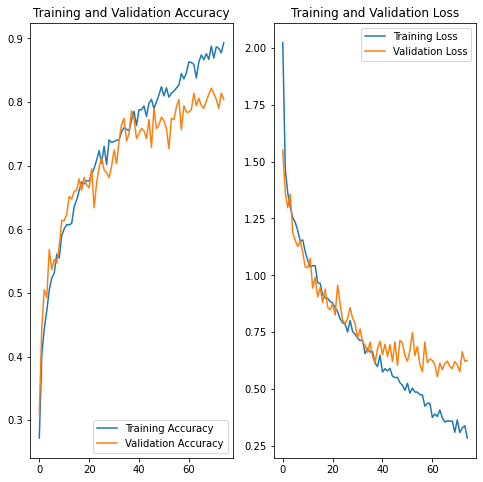

In [ ]:
val_loss_per_epoch = history.history['val_loss']
best_epoch_loss = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch by val_loss: %d' % (best_epoch_loss,))


val_acc_per_epoch = history.history['val_accuracy']
best_epoch_acc = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch by val_accuracy: %d' % (best_epoch_acc,))

print('Model Results')
print_results(history,75)

# Configurazione Finale
Alleniamo il modello finale, dopo aver individuato il numero ottimale di epoche.
Salviamo il modello per esportarlo e mostriamo la performance in fase di prediction.

In [17]:
# hypermodel = tuner.hypermodel.build(best_hps)

hypermodel = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(480, activation='relu'),
  layers.Dense(num_classes)
  ])

hypermodel.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# Retrain the model
hyper_history = hypermodel.fit(train_ds, validation_data=val_ds, epochs=63)

Epoch 1/63
64/64 [==============================] - 40s 335ms/step - loss: 2.1797 - accuracy: 0.3378 - val_loss: 1.3648 - val_accuracy: 0.4891
Epoch 2/63
64/64 [==============================] - 18s 286ms/step - loss: 1.3503 - accuracy: 0.4471 - val_loss: 1.2549 - val_accuracy: 0.5089
Epoch 3/63
64/64 [==============================] - 18s 286ms/step - loss: 1.2537 - accuracy: 0.5020 - val_loss: 1.2308 - val_accuracy: 0.4970
Epoch 4/63
64/64 [==============================] - 18s 285ms/step - loss: 1.1874 - accuracy: 0.5420 - val_loss: 1.0908 - val_accuracy: 0.5703
Epoch 5/63
64/64 [==============================] - 18s 285ms/step - loss: 1.1477 - accuracy: 0.5593 - val_loss: 1.1145 - val_accuracy: 0.5921
Epoch 6/63
64/64 [==============================] - 18s 286ms/step - loss: 1.1232 - accuracy: 0.5603 - val_loss: 1.0875 - val_accuracy: 0.5822
Epoch 7/63
64/64 [==============================] - 18s 284ms/step - loss: 1.0748 - accuracy: 0.5890 - val_loss: 1.0282 - val_accuracy: 0.6099

HModel Results


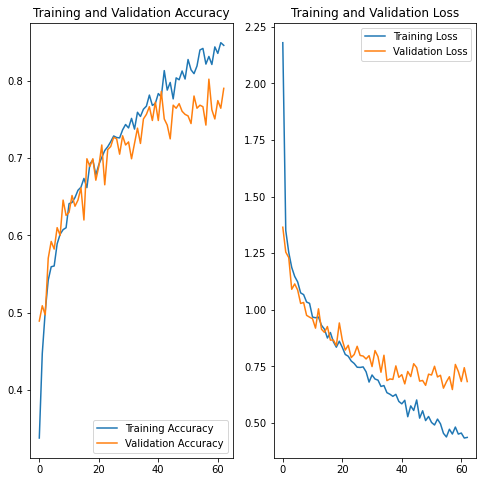

In [24]:
print('HModel Results')
print_results(hyper_history,63)

## Salvataggio Modello

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
hypermodel.save('junk_class.h5')

from google.colab import files
#files.download('junk_class.h5') 

## Load Modello

In [ ]:
model = tf.keras.models.load_model('junk_class.h5')

# Show the model architecture
# model.summary()

## Prediction

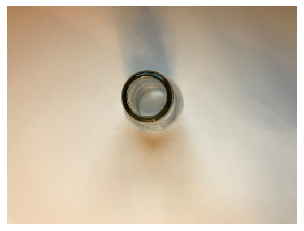

This image most likely belongs to glass with a 95.13 percent confidence.


In [26]:
image_path = pathlib.Path("/content/trashnet/data/dataset-resized/dataset-resized/glass/glass115.jpg")

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)

plt.imshow(img, interpolation='nearest')
plt.axis('off')
plt.show()

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch



predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)